Using whole video

In [15]:
import pandas as pd
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import cv2
from PIL import Image

In [16]:
# dataset directory
root_dir = r'/mnt/g/textures/texture recognition/gelsight dataset'

In [17]:
# dataframe with name of videos
training_data = pd.DataFrame()
videos = []
tags = os.listdir(root_dir)

for dir in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, dir)

    for vid_files in os.listdir(folder_path):
        videos.append(vid_files)

training_data['videos'] = videos
print(tags)

['S007', 'S029', 'S032', 'S033', 'S045', 'S064', 'S093', 'S094', 'S097', 'S100']


## Dataset preparing

In [5]:
# class VideoDataset(Dataset):
#     ''' 
#         A dataset class for handling pressure sensor data from GIF files.
#             Args:
#         - root_dir (str): Root directory where the dataset is stored.
#         - tags (list): List of labels corresponding to each sample.
    
#         Note: 
#         ['S005' -> 0 , 'S007' -> 1, 'S008' -> 2, 'S010'-> 3, 'S011'-> 4, 
#         'S014'-> 5, 'S016'-> 6, 'S044'-> 7, 'S054'-> 8, 'S055'-> 9]
        
#         Dataset = (frames, label)
#         number of frames vary for each dataset

#     '''
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.classes = os.listdir(root_dir)
#         self.video_paths = []
#         self.labels = []
#         self.frame_counts = []

#         for label, class_name in enumerate(self.classes):
#             class_dir = os.path.join(root_dir, class_name)
#             videos = os.listdir(class_dir)
#             for video in videos:
#                 if video.endswith('.avi'):
#                     video_path = os.path.join(class_dir, video)
#                     self.video_paths.append(video_path)
#                     self.labels.append(label)
#                     self.frame_counts.append(self.count_frames(video_path))
    
#     def __len__(self):
#         return len(self.video_paths)
    
#     def __getitem__(self, idx):
#         video_path = self.video_paths[idx]
#         frames = self.extract_frames(video_path)
        
#         if self.transform:
#             frames = [self.transform(Image.fromarray(frame)) for frame in frames]
        
#         frames_tensor = torch.stack([torch.tensor(np.array(frame)) for frame in frames])
#         label = self.labels[idx]
#         return frames_tensor, label
    
#     def extract_frames(self, video_path):
#         frames = []
#         cap = cv2.VideoCapture(video_path)
#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret:
#                 break
#             frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             frames.append(frame_rgb)
#         cap.release()
#         return frames
    
#     def count_frames(self, video_path):
#         cap = cv2.VideoCapture(video_path)
#         frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#         cap.release()
#         return frame_count

In [18]:
# 3DCNN 数据集定义
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=10):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames  # 固定帧数
        self.classes = os.listdir(root_dir)
        self.video_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            videos = os.listdir(class_dir)
            for video in videos:
                if video.endswith('.avi'):
                    video_path = os.path.join(class_dir, video)
                    self.video_paths.append(video_path)
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = self.extract_frames(video_path)
        
        if self.transform:
            frames = [self.transform(Image.fromarray(frame)) for frame in frames]
        
        frames_tensor = torch.stack([torch.tensor(np.array(frame)) for frame in frames])
        frames_tensor = frames_tensor.permute(1, 0, 2, 3)  # 调整维度为 (channels, frames, height, width)
        label = self.labels[idx]
        return frames_tensor, label
    
    def extract_frames(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # 选择中间的 num_frames 帧
        if total_frames > self.num_frames:
            start_frame = (total_frames // 2) - (self.num_frames // 2)
            selected_frames = range(start_frame, start_frame + self.num_frames)
        else:
            # 如果视频帧数少于固定帧数，重复最后一帧进行填充
            selected_frames = range(total_frames)
        
        for i in selected_frames:
            if i < total_frames:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if ret:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame_rgb)
            else:
                # 如果帧数不足，使用最后一帧进行填充
                frames.append(frames[-1])
        
        cap.release()
        return frames

# 预处理
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
dataset = VideoDataset('/mnt/g/textures/texture recognition/gelsight dataset', transform=transform)

In [34]:
# CNNLSTM数据
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=20):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames  # 固定帧数
        self.classes = os.listdir(root_dir)
        self.video_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            videos = os.listdir(class_dir)
            for video in videos:
                if video.endswith('.avi'):
                    video_path = os.path.join(class_dir, video)
                    self.video_paths.append(video_path)
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = self.extract_frames(video_path)
        
        if self.transform:
            frames = [self.transform(Image.fromarray(frame)) for frame in frames]
        
        frames_tensor = torch.stack([torch.tensor(np.array(frame)) for frame in frames])
        label = self.labels[idx]
        return frames_tensor, label
    
    def extract_frames(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # 选择中间的 num_frames 帧
        if total_frames > self.num_frames:
            start_frame = (total_frames // 2) - (self.num_frames // 2)
            selected_frames = range(start_frame, start_frame + self.num_frames)
        else:
            # 如果视频帧数少于固定帧数，重复最后一帧进行填充
            selected_frames = range(total_frames)
        
        for i in selected_frames:
            if i < total_frames:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if ret:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame_rgb)
            else:
                # 如果帧数不足，使用最后一帧进行填充
                frames.append(frames[-1])
        
        cap.release()
        return frames
transform = transforms.Compose([transforms.Resize(size=(224,224)), transforms.ToTensor()])
dataset = VideoDataset(root_dir, transform=transform, num_frames=20)

In [6]:
# transform = transforms.Compose([transforms.Resize(size=(224,224)), transforms.ToTensor()])
# dataset = VideoDataset(root_dir, transform=transform)

In [19]:
a,b = dataset[1]
a.size()


torch.Size([3, 10, 128, 128])

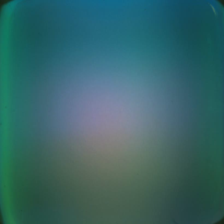

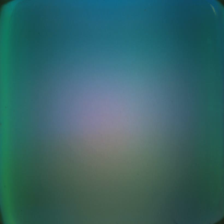

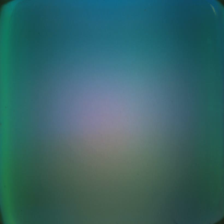

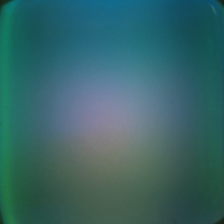

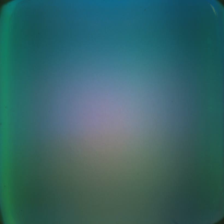

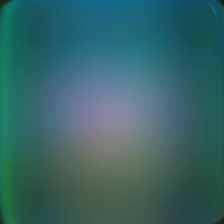

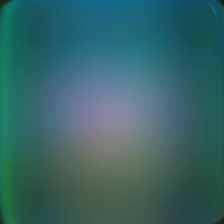

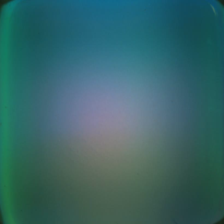

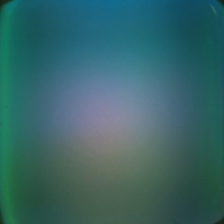

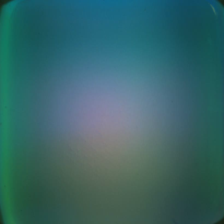

In [8]:
# checking dataset prepared

import torch
from PIL import Image
import torchvision.transforms as transforms


def visualize_frame_pil(frame_tensor):
 
    transform = transforms.ToPILImage()
    frame_pil = transform(frame_tensor)
    frame_pil.show()


for i in range(10):  # visualize the first 10 frames as an example
    visualize_frame_pil(a[i])


- Each video yeilds different number of frames
- hence trying out processing frames one by one

# CNN + LSTM model

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import resnet18
from tqdm import tqdm

In [13]:
class C3D(nn.Module):
    def __init__(self, num_classes):
        super(C3D, self).__init__()
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1)
        self.bn2 = nn.BatchNorm3d(128)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=1)
        self.bn3a = nn.BatchNorm3d(256)
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=1)
        self.bn3b = nn.BatchNorm3d(256)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=1)
        self.bn4a = nn.BatchNorm3d(512)
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=1)
        self.bn4b = nn.BatchNorm3d(512)
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=1)
        self.bn5a = nn.BatchNorm3d(512)
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=1)
        self.bn5b = nn.BatchNorm3d(512)
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.fc6 = nn.Linear(512 * 4 * 4, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, num_classes)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.pool1(h)

        h = F.relu(self.bn2(self.conv2(h)))
        h = self.pool2(h)

        h = F.relu(self.bn3a(self.conv3a(h)))
        h = F.relu(self.bn3b(self.conv3b(h)))
        h = self.pool3(h)

        h = F.relu(self.bn4a(self.conv4a(h)))
        h = F.relu(self.bn4b(self.conv4b(h)))
        h = self.pool4(h)

        h = F.relu(self.bn5a(self.conv5a(h)))
        h = F.relu(self.bn5b(self.conv5b(h)))
        h = self.pool5(h)

        h = h.view(h.size(0), -1)  # Flatten the tensor
        h = F.relu(self.fc6(h))
        h = F.dropout(h, 0.5)

        h = F.relu(self.fc7(h))
        h = F.dropout(h, 0.5)

        logits = self.fc8(h)
        return logits



Epoch 1/20


100%|██████████| 80/80 [01:04<00:00,  1.24it/s]


Training Loss: 2.9288
Epoch 2/20


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Training Loss: 2.5470
Epoch 3/20


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Training Loss: 2.4795
Epoch 4/20


100%|██████████| 80/80 [01:04<00:00,  1.24it/s]


Training Loss: 2.4609
Epoch 5/20


100%|██████████| 80/80 [01:06<00:00,  1.20it/s]


Training Loss: 2.4262
Epoch 6/20


100%|██████████| 80/80 [01:03<00:00,  1.25it/s]


Training Loss: 2.3689
Epoch 7/20


100%|██████████| 80/80 [01:04<00:00,  1.23it/s]


Training Loss: 2.3424
Epoch 8/20


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Training Loss: 2.3451
Epoch 9/20


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Training Loss: 2.3077
Epoch 10/20


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Training Loss: 2.3008
Epoch 11/20


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Training Loss: 2.3056
Epoch 12/20


100%|██████████| 80/80 [01:03<00:00,  1.25it/s]


Training Loss: 2.3023
Epoch 13/20


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Training Loss: 2.2884
Epoch 14/20


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Training Loss: 2.2957
Epoch 15/20


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Training Loss: 2.2849
Epoch 16/20


100%|██████████| 80/80 [01:04<00:00,  1.24it/s]


Training Loss: 2.3050
Epoch 17/20


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Training Loss: 2.3053
Epoch 18/20


100%|██████████| 80/80 [01:03<00:00,  1.25it/s]


Training Loss: 2.2682
Epoch 19/20


100%|██████████| 80/80 [01:04<00:00,  1.24it/s]


Training Loss: 2.2769
Epoch 20/20


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Training Loss: 2.3041


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Test Loss: 2.2796, Accuracy: 0.0500


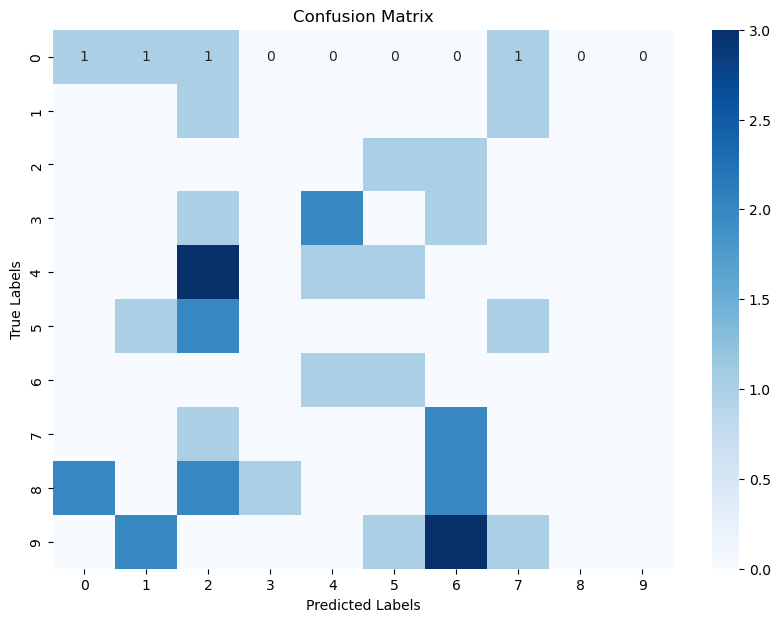

In [14]:
# 加载模型到GPU
model = C3D(num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# 学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 数据加载
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# 训练函数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for frames, labels in tqdm(train_loader):
        frames, labels = frames.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(frames)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Training Loss: {avg_loss:.4f}")

# 测试函数，输出准确率和混淆矩阵
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def test(model, test_loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0

    with torch.no_grad():
        for frames, labels in tqdm(test_loader):
            frames, labels = frames.to(device), labels.to(device)
            
            outputs = model(frames)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    # 绘制混淆矩阵
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# 开始训练和测试
num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    scheduler.step()
test(model, test_loader, criterion, device)

In [31]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNNLSTM, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 512))
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=3)
        self.fc = nn.Linear(256, num_classes)
       
    def forward(self, frames):
        batch_size, seq_len, _, _, _ = frames.size()
        hidden = None

        for t in range(seq_len):
            x = self.resnet(frames[:,t])  
            out, hidden = self.lstm(x.unsqueeze(0), hidden)  

        lstm_out = hidden[0][-1]
        model_output = lstm_out.view(batch_size, -1)
        model_output = self.fc(lstm_out)
        class_scores = F.softmax(model_output, dim=1)

        return lstm_out, class_scores


In [32]:
model = CNNLSTM(10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNLSTM(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Epoch 1/10


100%|██████████| 40/40 [01:11<00:00,  1.79s/it]


Training Loss: 2.2992


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]

Test Loss: 2.3042, Accuracy: 0.0500


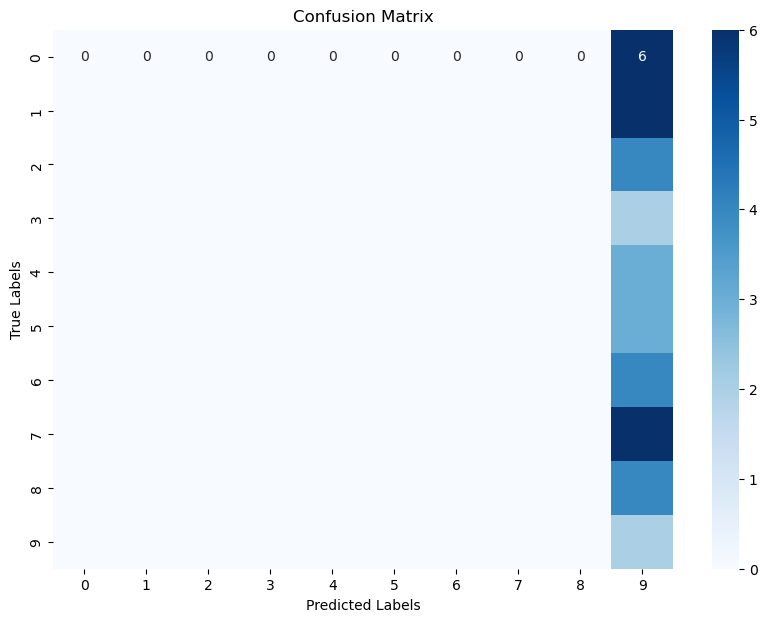

Epoch 2/10


100%|██████████| 40/40 [01:12<00:00,  1.82s/it]


Training Loss: 2.2987


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]

Test Loss: 2.2217, Accuracy: 0.1750


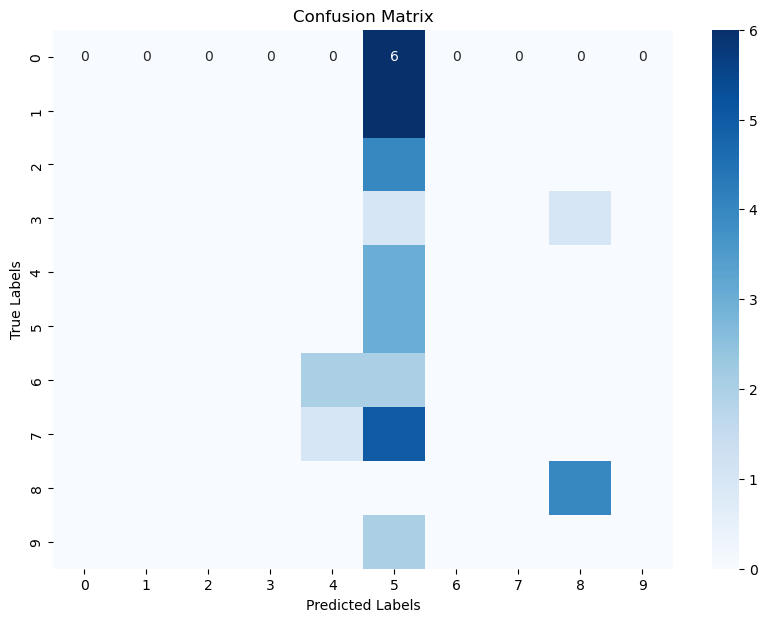

Epoch 3/10


100%|██████████| 40/40 [01:11<00:00,  1.80s/it]


Training Loss: 2.2732


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]

Test Loss: 2.2194, Accuracy: 0.1750


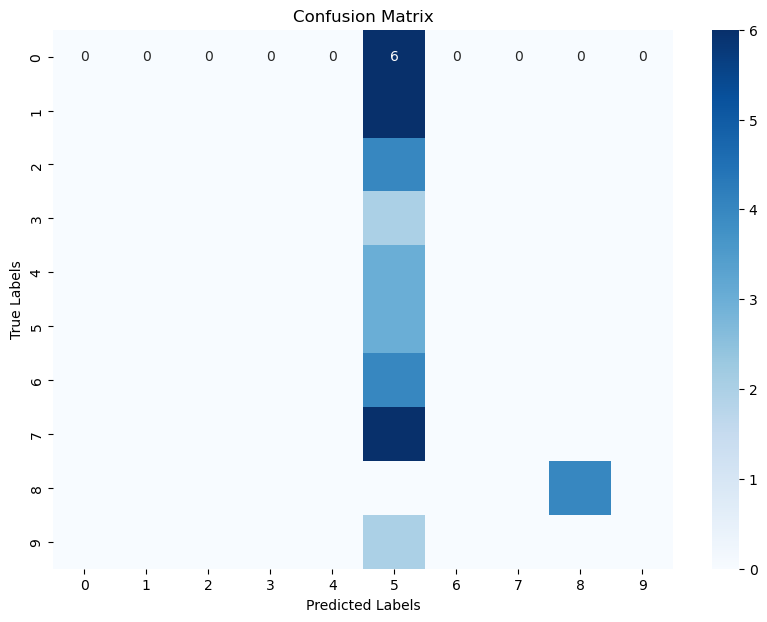

Epoch 4/10


100%|██████████| 40/40 [01:11<00:00,  1.80s/it]


Training Loss: 2.2758


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]

Test Loss: 2.3303, Accuracy: 0.0500


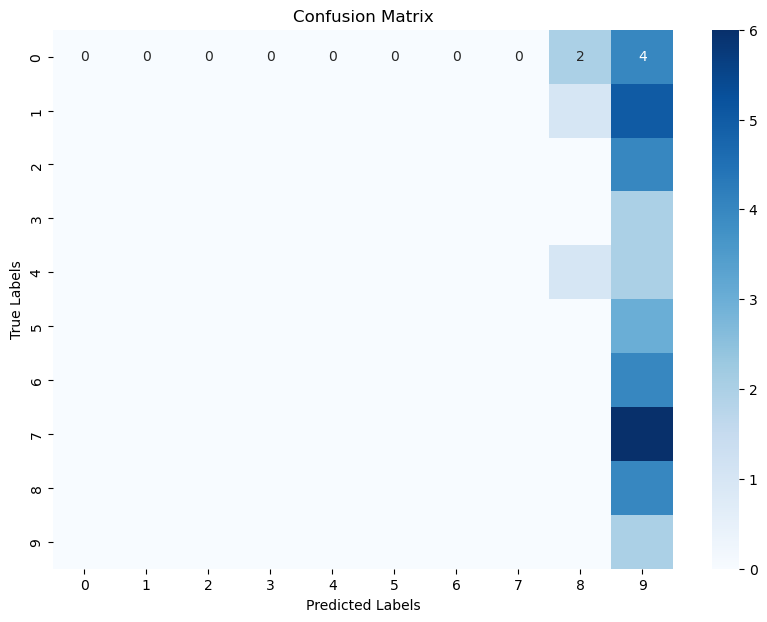

Epoch 5/10


100%|██████████| 40/40 [01:11<00:00,  1.79s/it]


Training Loss: 2.3380


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]

Test Loss: 2.4414, Accuracy: 0.0000


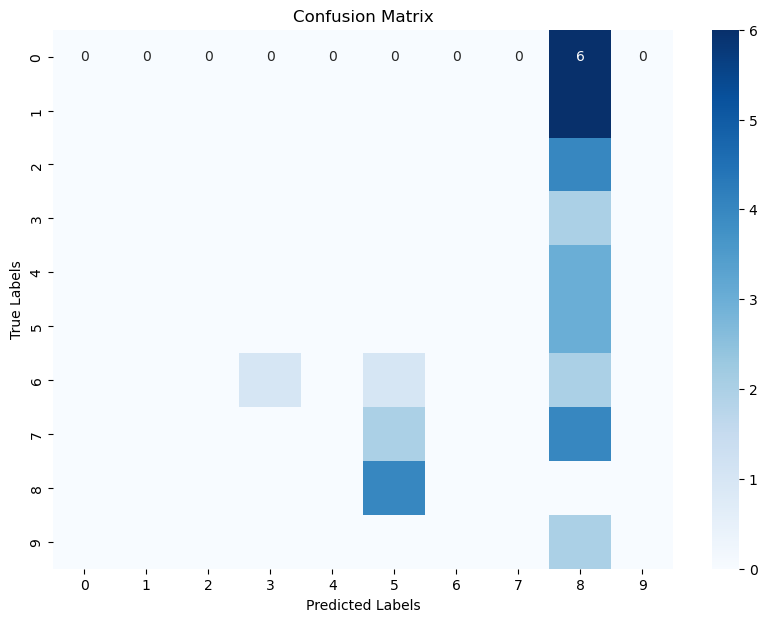

Epoch 6/10


 65%|██████▌   | 26/40 [00:48<00:25,  1.85s/it]


KeyboardInterrupt: 

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 数据集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# 训练循环
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for frames, labels in tqdm(train_loader):
        frames, labels = frames.to(device), labels.to(device)
        
        optimizer.zero_grad()
        _, outputs = model(frames)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Training Loss: {avg_loss:.4f}")
    return avg_loss

# 测试过程，包括准确率和混淆矩阵
def test(model, test_loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0

    with torch.no_grad():
        for frames, labels in tqdm(test_loader):
            frames, labels = frames.to(device), labels.to(device)
            
            _, outputs = model(frames)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    # 绘制混淆矩阵
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# 训练和测试过程
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_loader, criterion, optimizer, device)
test(model, test_loader, criterion, device)

Extracting Features: 100%|██████████| 200/200 [03:29<00:00,  1.05s/sample]

Accuracy: 0.1000


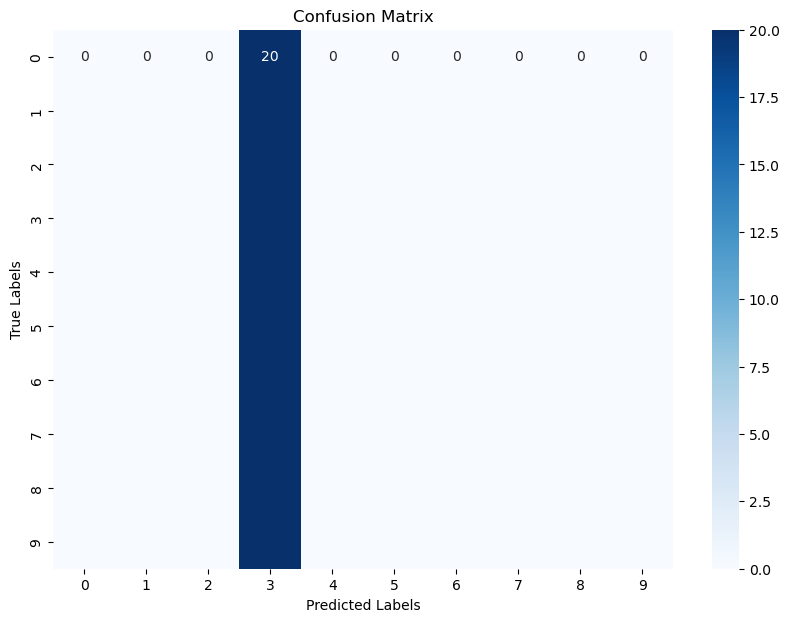

In [17]:
model.eval()

feature_vectors = []
true_labels = []
predicted_labels = []

with torch.no_grad(), tqdm(total=len(dataset), desc='Extracting Features', unit='sample') as pbar:
    for frames, label in dataset:
        frames = frames.to(device)
        lstm_out, model_output = model(frames.unsqueeze(0))

        feature_vectors.append(lstm_out.squeeze().cpu().numpy())
        true_labels.append(label)

        # 获取预测标签
        predicted_label = torch.argmax(model_output, dim=1).cpu().numpy()
        predicted_labels.append(predicted_label[0])

        pbar.update(1)

# 将数据转换为numpy数组
feature_vectors = np.array(feature_vectors)
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# 计算准确率
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Dim-Red using UMAP 

In [18]:
new_labels = []
for i in range(len(labels)):
    new_labels.append(str(tags[labels[i]]))
    
print(new_labels)

['S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S007', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S029', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S032', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S033', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S045', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S064', 'S093', 'S093', 'S093', 'S093', 'S093',

In [19]:
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import seaborn as sns


/home/admins/miniconda3/envs/myenv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


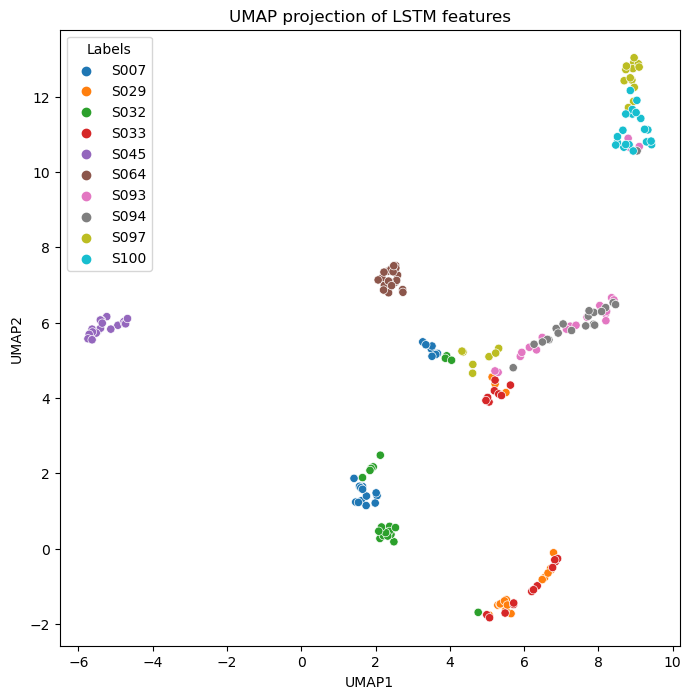

In [20]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_vectors)

umap = UMAP(n_components=2, random_state=150)
umap_features = umap.fit_transform(scaled_features)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=umap_features[:, 0], y=umap_features[:, 1], hue=new_labels, palette='tab10')
plt.title('UMAP projection of LSTM features')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Labels')
plt.show()


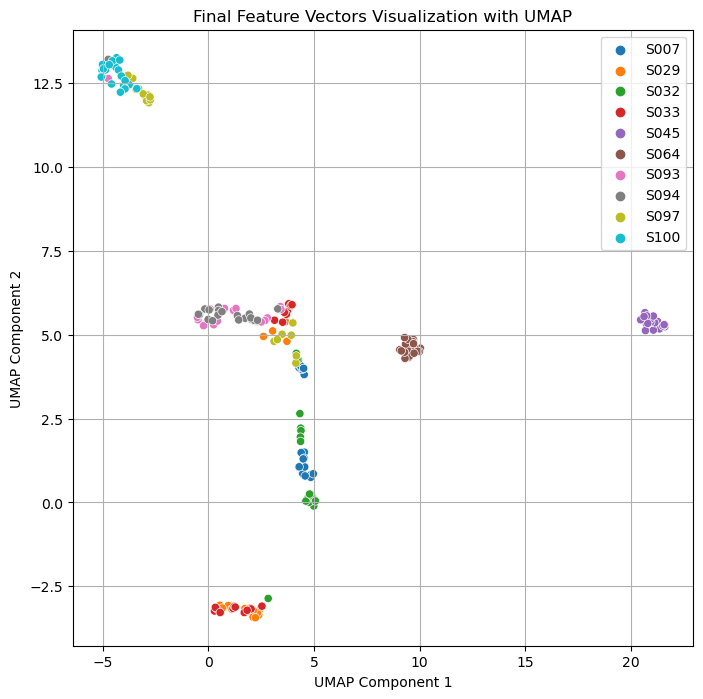

In [21]:
umap2 = UMAP(n_components=2)

new_features = umap2.fit_transform(feature_vectors)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=new_features[:, 0], y=new_features[:, 1], hue=new_labels, palette='tab10')
plt.title('Final Feature Vectors Visualization with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()




T-SNE

In [22]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

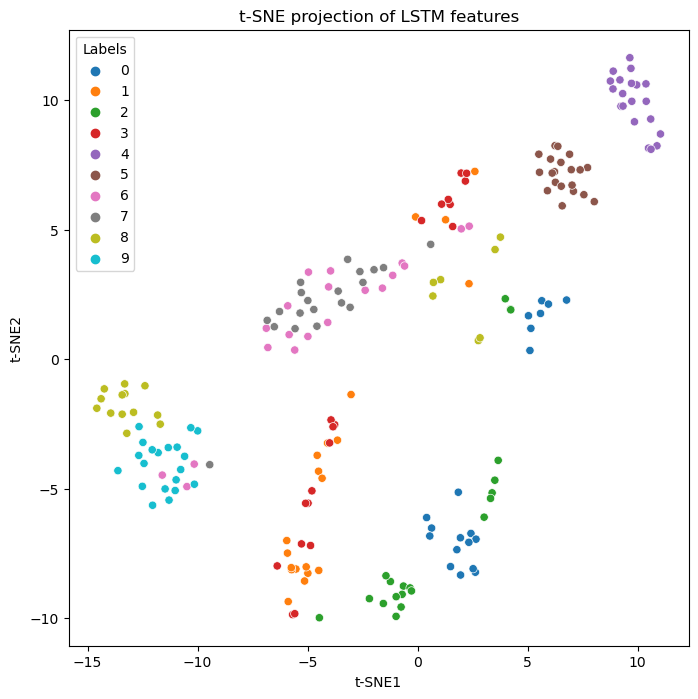

In [23]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_vectors)

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette='tab10')
plt.title('t-SNE projection of LSTM features')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend(title='Labels')
plt.show()